# Clustering Algorithm Comparison

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import (
    KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering,
    MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS
)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import time
import os
import csv
import pandas as pd
import seaborn as sns

# Set random seed for reproducibility

In [3]:
np.random.seed(42)

## 1. Dataset Generation

In [4]:
def generate_datasets(n_samples=1500, random_state=42):
    """Generate synthetic datasets."""
    # Generate anisotropic dataset
    X_aniso, y_aniso = make_blobs(n_samples=n_samples//2, centers=3, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X_aniso, transformation)

    # Generate circles dataset
    X_circles, y_circles = make_circles(n_samples=n_samples//2, factor=0.5, noise=0.05, random_state=random_state)

    # Create combined dataset
    X_combined = np.vstack([X_aniso, X_circles])
    y_combined = np.hstack([y_aniso, y_circles + 2])

    return {
        'aniso': (X_aniso, y_aniso),
        'circles': (X_circles, y_circles),
        'combined_aniso_circles': (X_combined, y_combined)
    }

# Generate datasets
datasets = generate_datasets()


### Visualize datasets

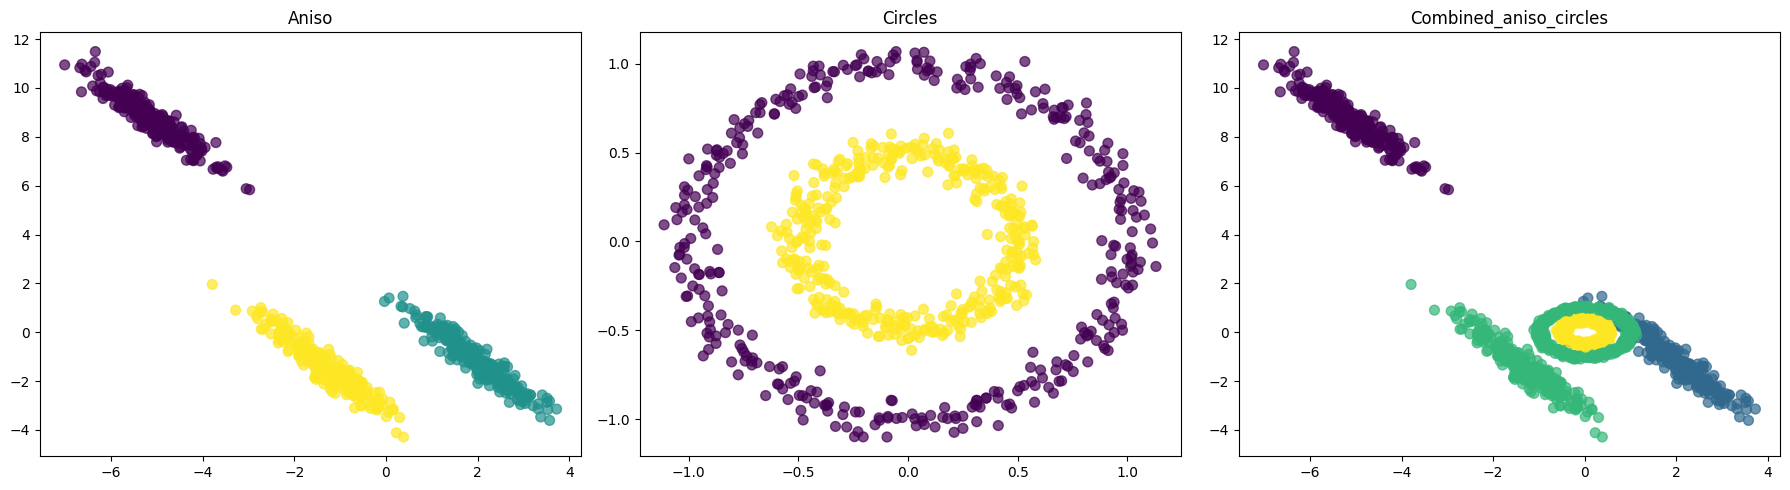

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, (X, y)) in zip(axes, datasets.items()):
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, alpha=0.7, cmap='viridis')
    ax.set_title(name.capitalize())
plt.tight_layout()
plt.show()

## 2. Clustering Algorithms Setup

In [6]:
def get_clustering_algorithms():
    """Define clustering algorithms to be tested."""
    return {
        'KMeans': KMeans(n_clusters=3, random_state=42),
        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=3, random_state=42),
        'AffinityPropagation': AffinityPropagation(random_state=42),
        'MeanShift': MeanShift(bandwidth=2),
        'SpectralClustering': SpectralClustering(n_clusters=3, random_state=42),
        'Ward': AgglomerativeClustering(n_clusters=3, linkage='ward'),
        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=3),
        'DBSCAN': DBSCAN(eps=0.3, min_samples=5),
        'OPTICS': OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1),
        'Birch': Birch(n_clusters=3),
        'GaussianMixture': GaussianMixture(n_components=3, random_state=42)
    }

algorithms = get_clustering_algorithms()

## 3. Evaluation Functions

In [13]:
def evaluate_clustering(X, labels):
    """Evaluate clustering results using multiple metrics."""
    if len(np.unique(labels)) < 2:
        return None, None, None
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    return silhouette, calinski, davies

def plot_clustering_results(dataset_name, X, all_labels):
    """Plot all clustering results for a single dataset."""
    n_algorithms = len(all_labels)
    n_cols = 3
    n_rows = (n_algorithms + n_cols) // n_cols

    plt.figure(figsize=(20, 6 * n_rows))

    # Plot original dataset
    plt.subplot(n_rows, n_cols, 1)
    plt.scatter(X[:, 0], X[:, 1], c='blue', s=50, alpha=0.7)
    plt.title(f"Original {dataset_name.capitalize()} Dataset")

    # Plot results for each algorithm
    for idx, (algo_name, result) in enumerate(all_labels.items(), start=2):
        plt.subplot(n_rows, n_cols, idx)
        scatter = plt.scatter(X[:, 0], X[:, 1], c=result['labels'], cmap='viridis', s=50, alpha=0.7)
        plt.colorbar(scatter)
        # Check if values are None before formatting
        title = f"{algo_name}\nClusters: {result['n_clusters'] if result['n_clusters'] is not None else 'N/A'}"
        title += f"\nSilhouette: {result['silhouette']:.2f}" if result['silhouette'] is not None else "\nSilhouette: N/A"
        plt.title(title)

    plt.tight_layout()
    plt.show()

## 4. Run Clustering Experiments


Processing dataset: aniso
Running KMeans...
Running MiniBatchKMeans...
Running AffinityPropagation...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Running MeanShift...
Running SpectralClustering...
Running Ward...
Running AgglomerativeClustering...
Running DBSCAN...
Running OPTICS...
Running Birch...
Running GaussianMixture...


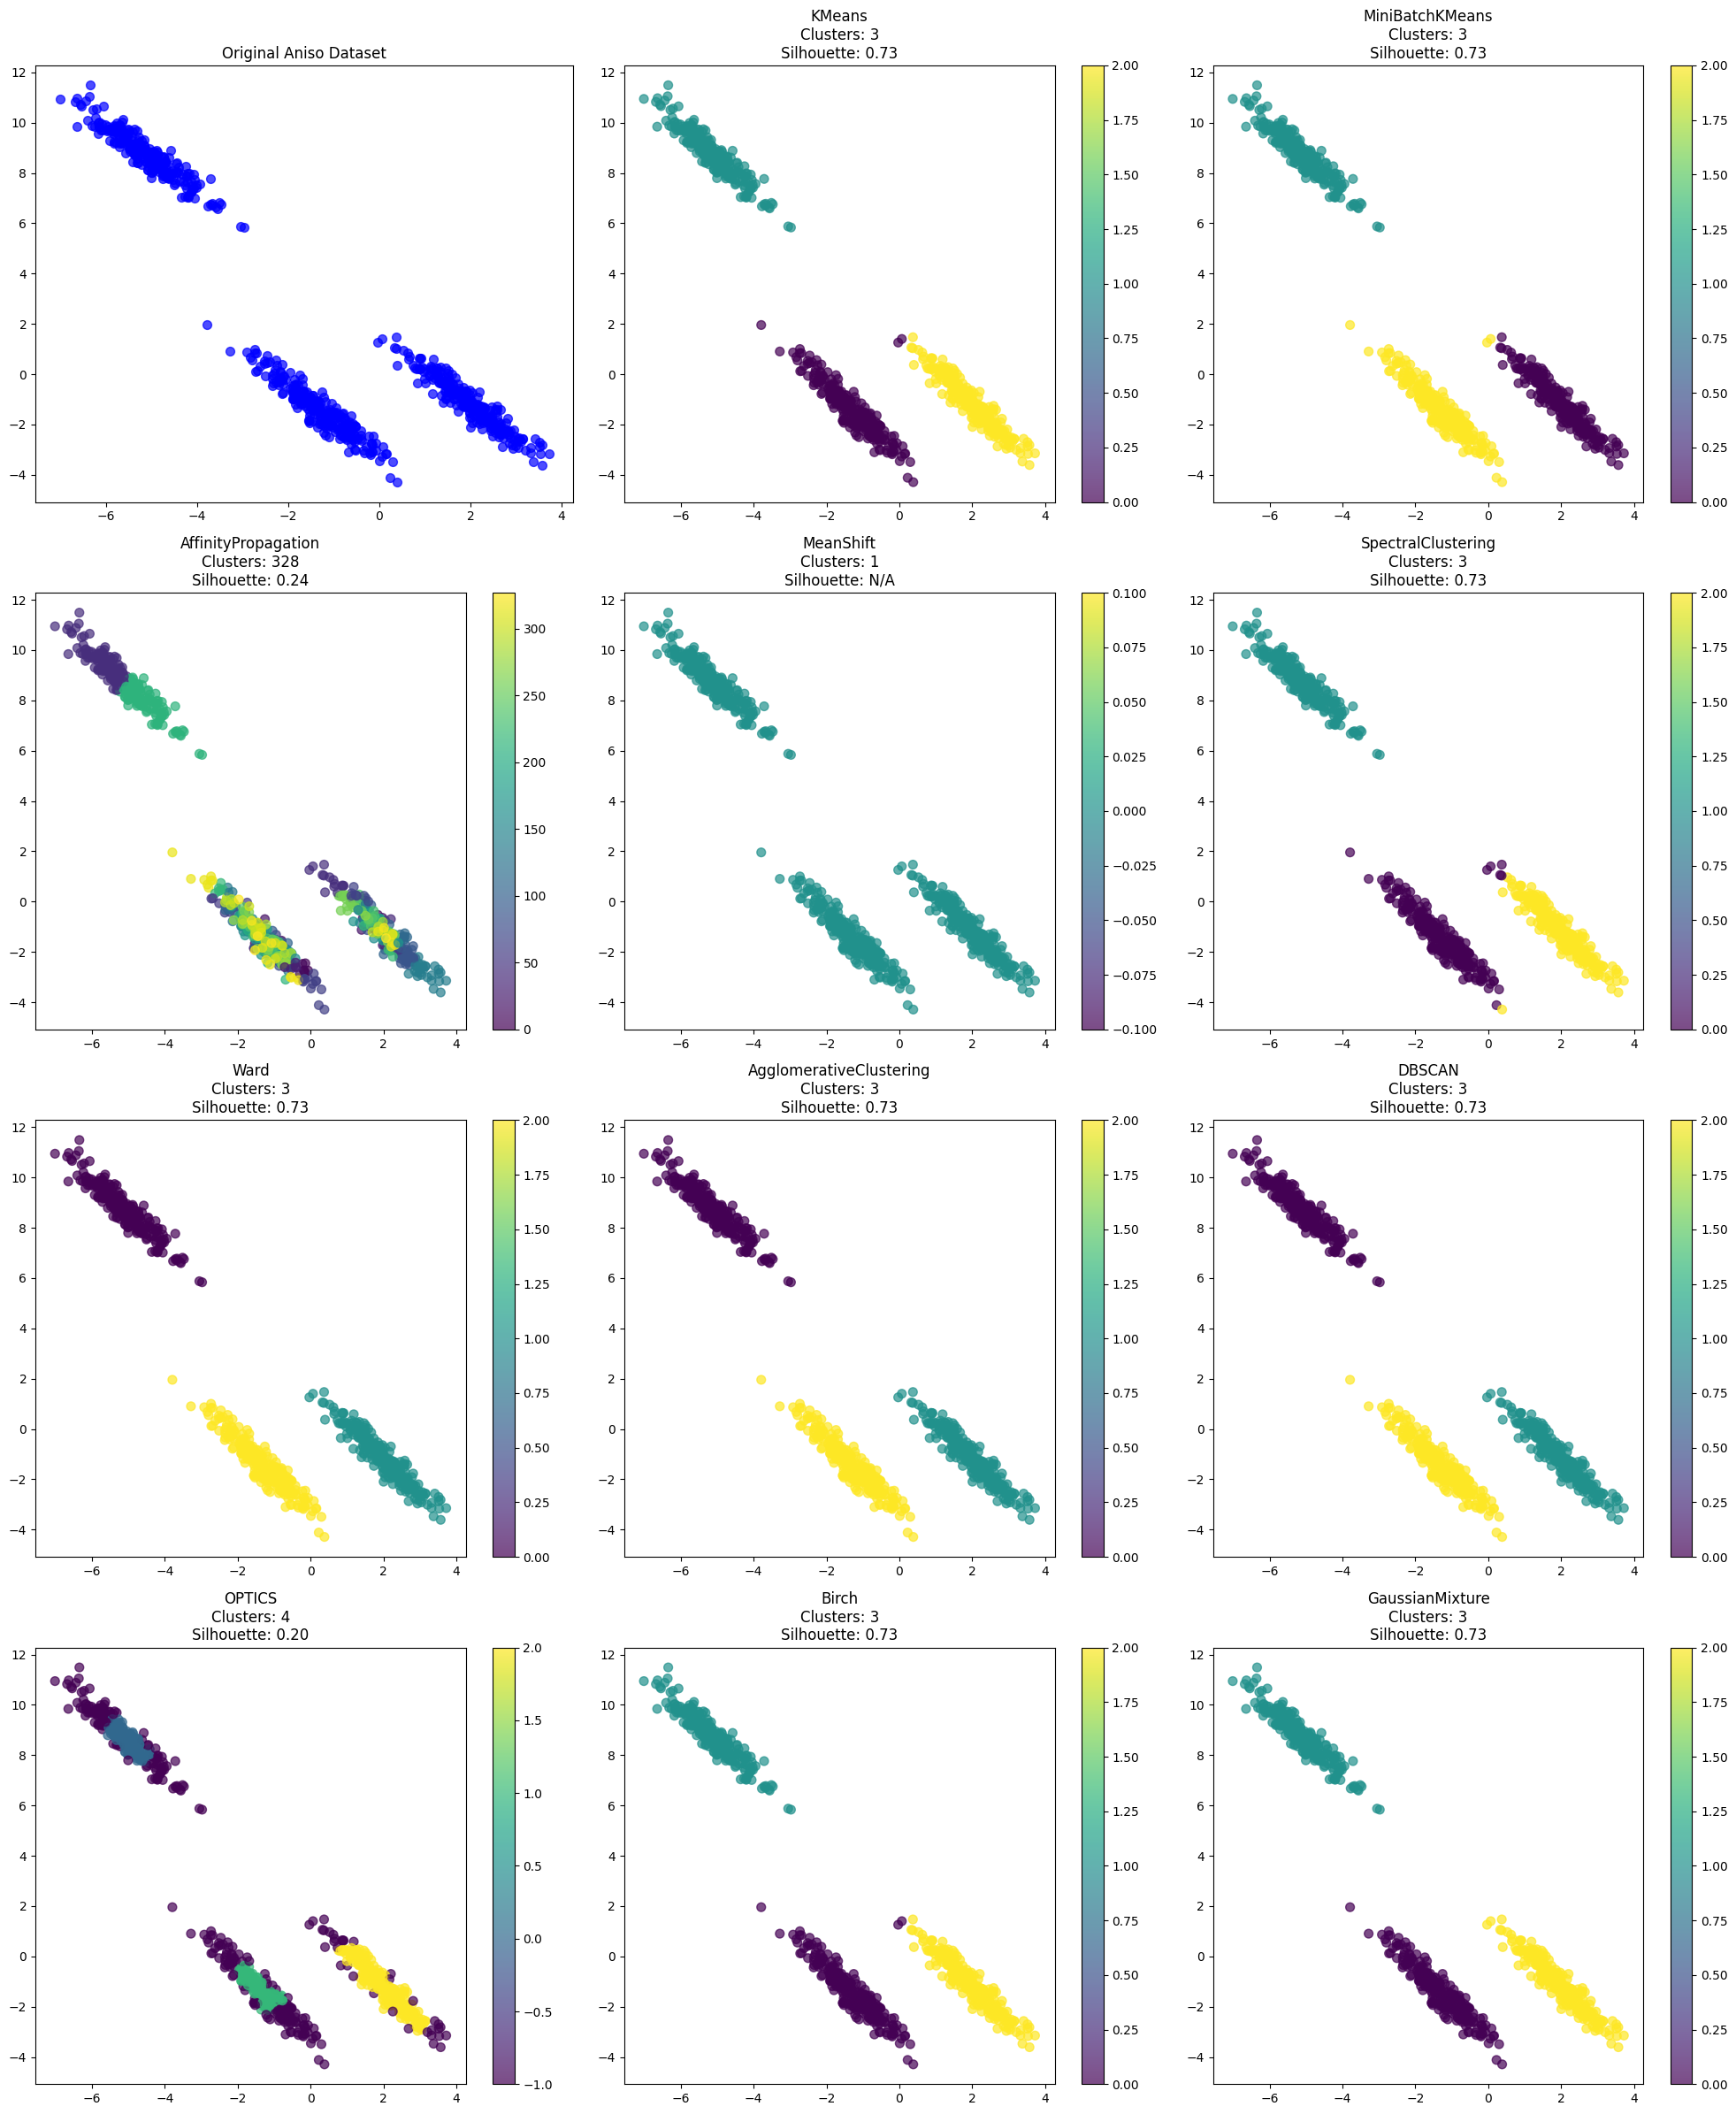


Processing dataset: circles
Running KMeans...
Running MiniBatchKMeans...
Running AffinityPropagation...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Running MeanShift...
Running SpectralClustering...
Running Ward...
Running AgglomerativeClustering...
Running DBSCAN...
Running OPTICS...
Running Birch...
Running GaussianMixture...


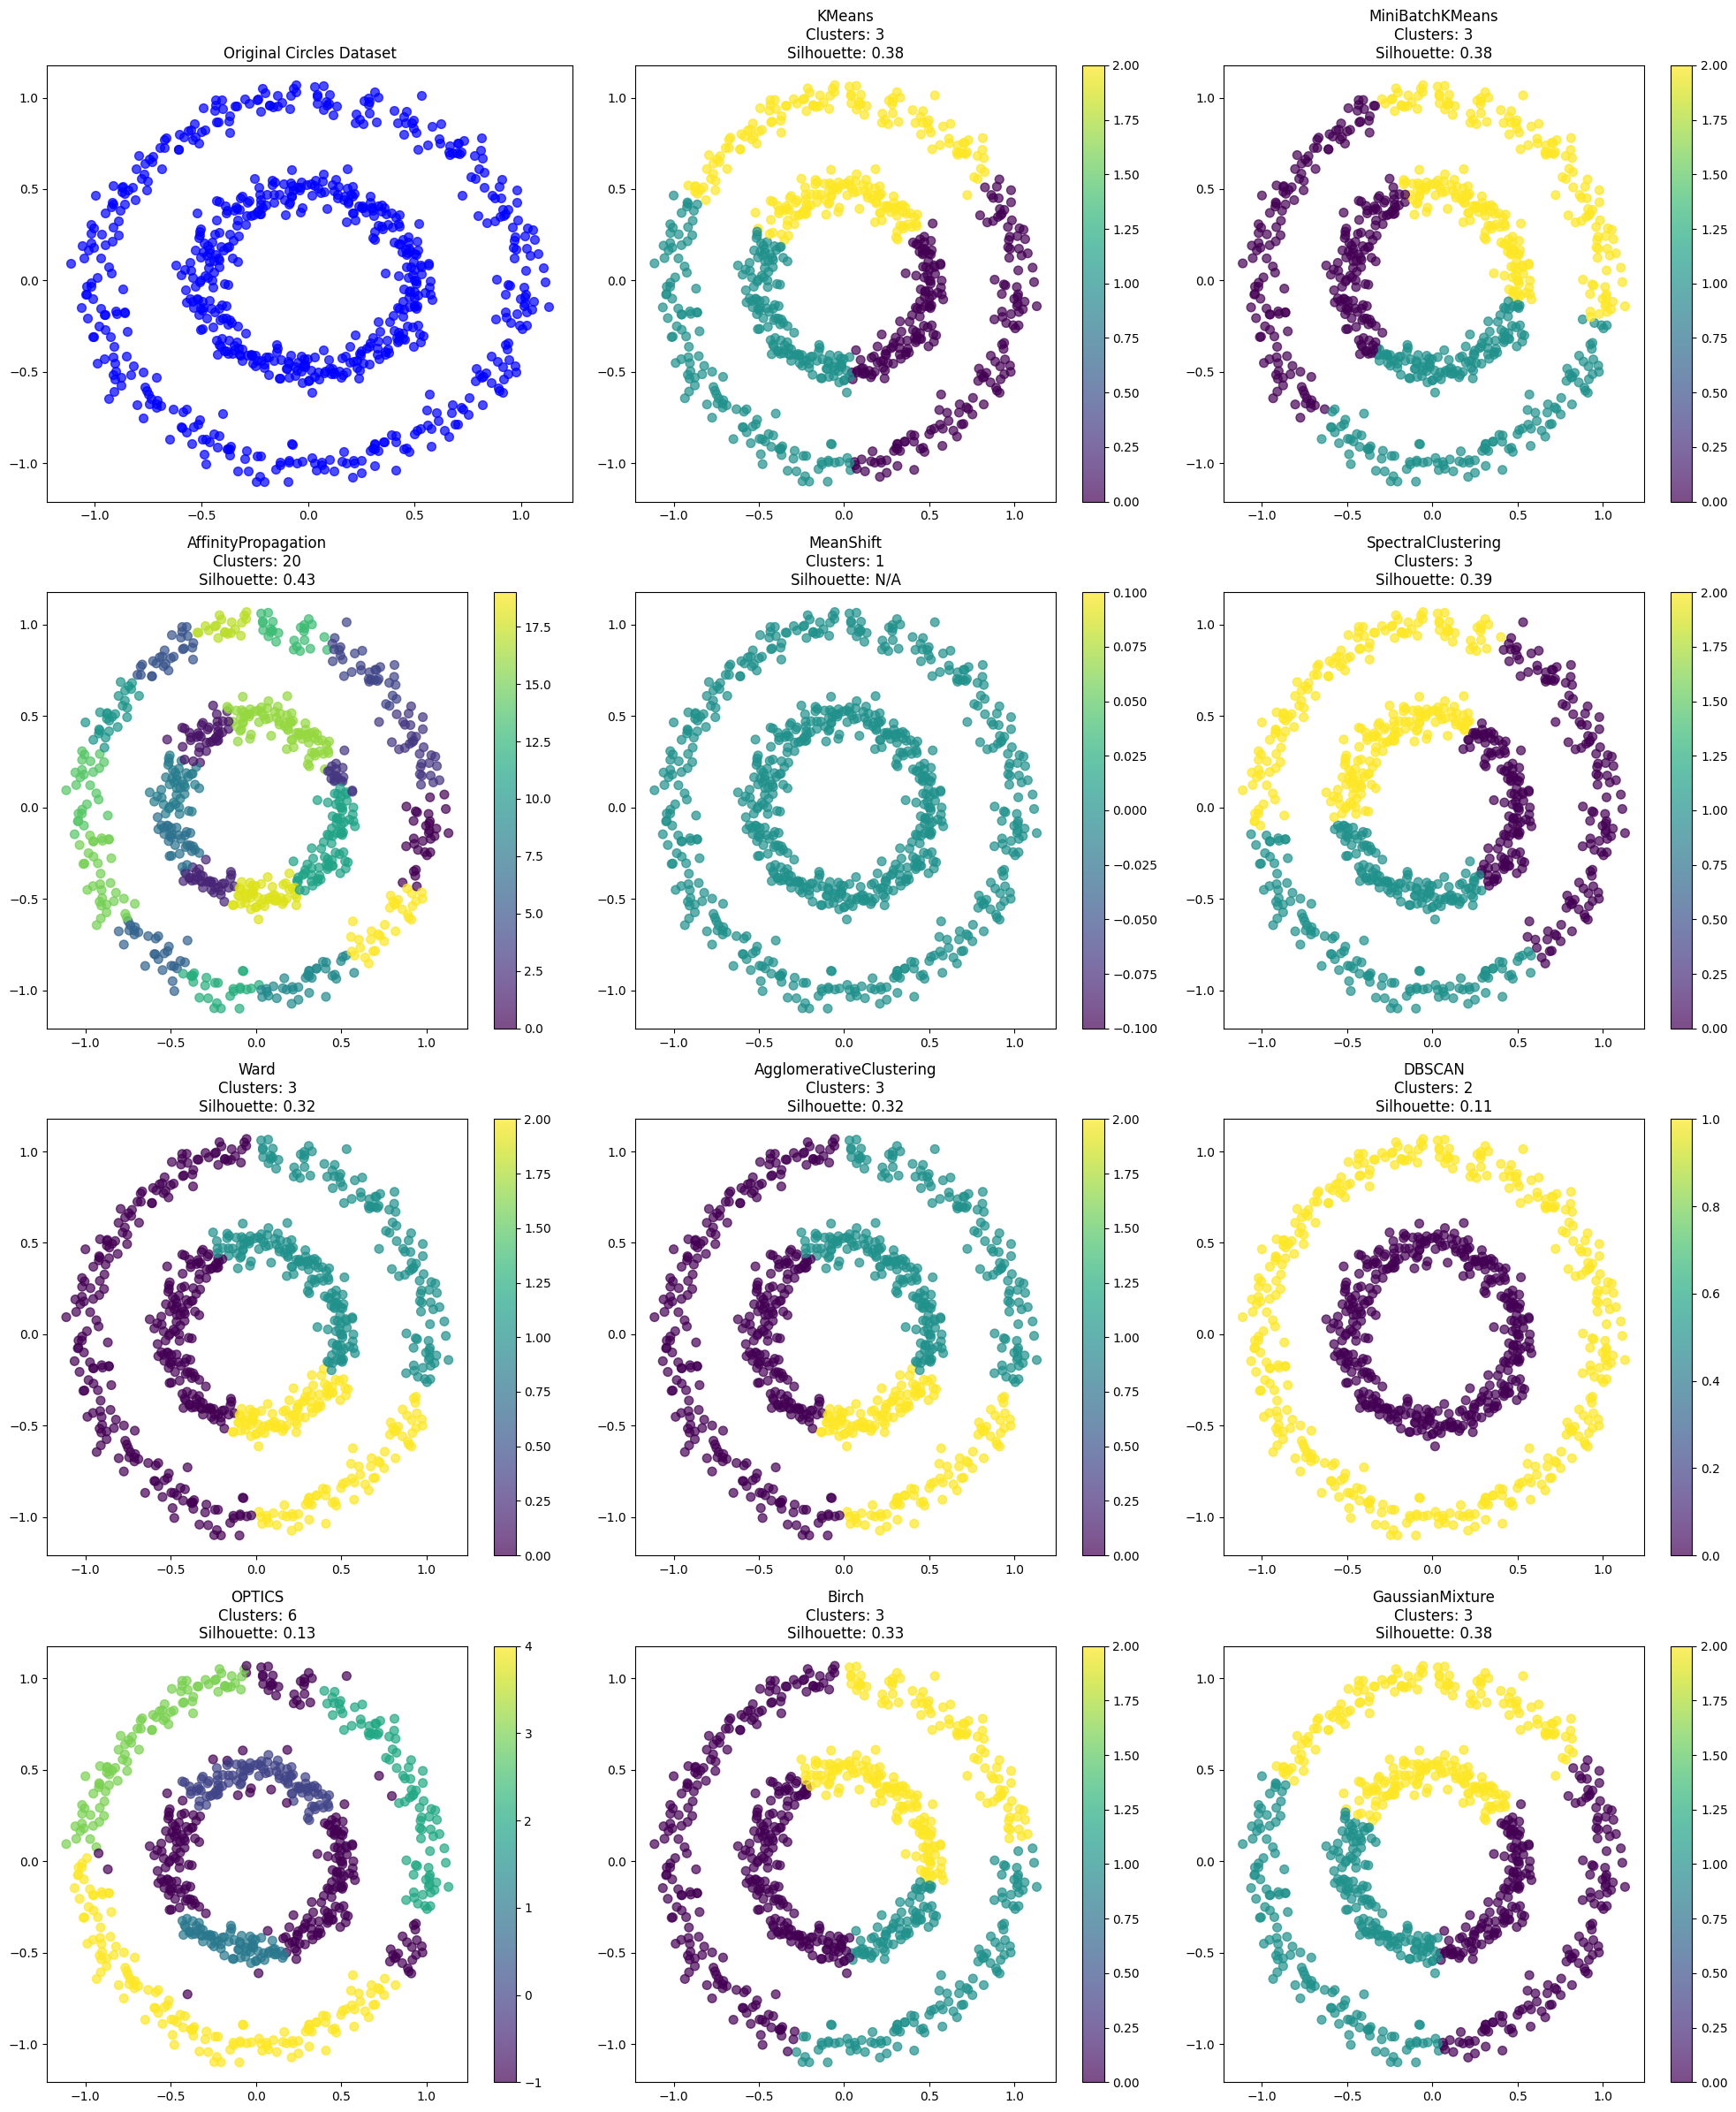


Processing dataset: combined_aniso_circles
Running KMeans...
Running MiniBatchKMeans...
Running AffinityPropagation...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Running MeanShift...
Running SpectralClustering...
Running Ward...
Running AgglomerativeClustering...
Running DBSCAN...
Running OPTICS...
Running Birch...
Running GaussianMixture...


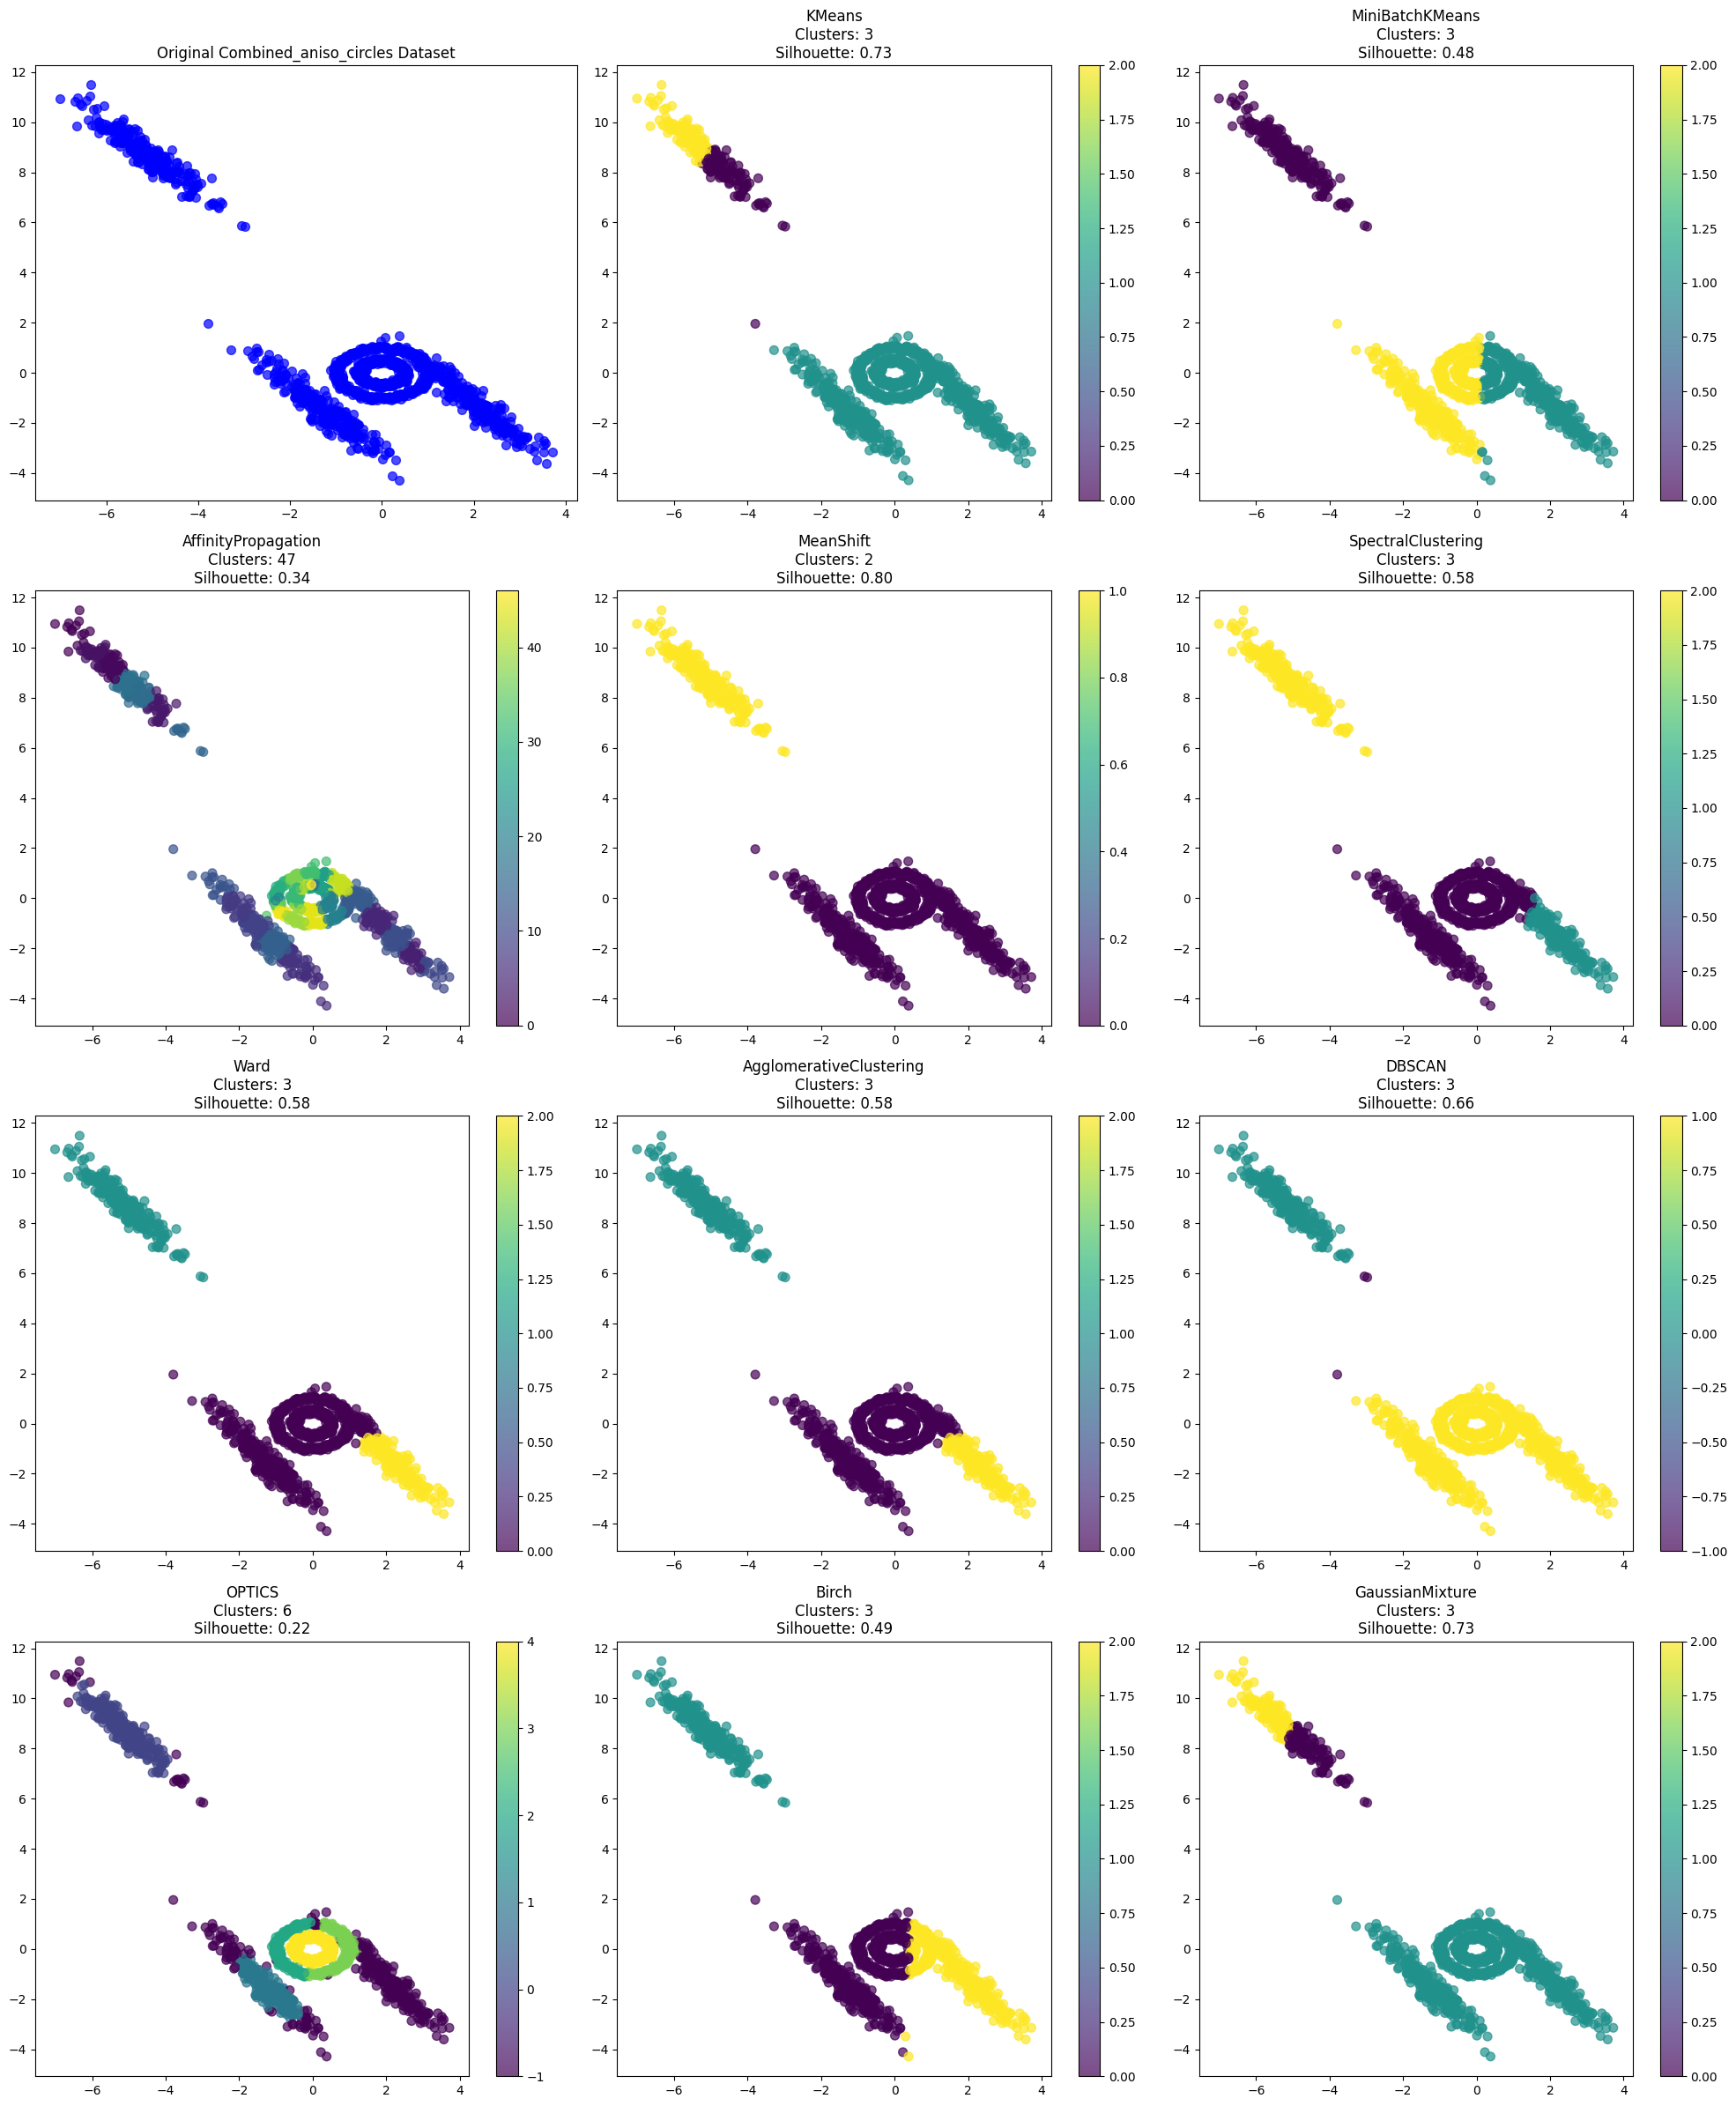

In [14]:
all_results = {}

for dataset_name, (X, y_true) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    dataset_results = {}

    for algo_name, algorithm in algorithms.items():
        print(f"Running {algo_name}...")
        start_time = time.time()

        try:
            if algo_name == 'MeanShift':
                algorithm.fit(X_scaled)
                labels = algorithm.labels_
            else:
                labels = algorithm.fit_predict(X_scaled)

            execution_time = time.time() - start_time
            silhouette, calinski, davies = evaluate_clustering(X_scaled, labels)

            dataset_results[algo_name] = {
                'labels': labels,
                'time': execution_time,
                'silhouette': silhouette,
                'calinski': calinski,
                'davies': davies,
                'n_clusters': len(np.unique(labels))
            }

        except Exception as e:
            print(f"Error with {algo_name}: {str(e)}")
            dataset_results[algo_name] = {
                'labels': None,
                'time': None,
                'silhouette': None,
                'calinski': None,
                'davies': None,
                'n_clusters': None
            }

    # Store results and visualize
    all_results[dataset_name] = dataset_results
    plot_clustering_results(dataset_name, X, dataset_results)


## 5. Results Analysis

In [16]:
results_list = []
for dataset_name, dataset_results in all_results.items():
    for algo_name, result in dataset_results.items():
        results_list.append({
            'Dataset': dataset_name,
            'Algorithm': algo_name,
            'Time': result['time'],
            'Clusters': result['n_clusters'],
            'Silhouette': result['silhouette'],
            'Calinski': result['calinski'],
            'Davies': result['davies']
        })

results_df = pd.DataFrame(results_list)
display(results_df)


Dataset                Algorithm      Time  Clusters  \
0                    aniso                   KMeans  0.005409         3   
1                    aniso          MiniBatchKMeans  0.007213         3   
2                    aniso      AffinityPropagation  1.468895       328   
3                    aniso                MeanShift  2.892065         1   
4                    aniso       SpectralClustering  0.155405         3   
5                    aniso                     Ward  0.024497         3   
6                    aniso  AgglomerativeClustering  0.035063         3   
7                    aniso                   DBSCAN  0.008338         3   
8                    aniso                   OPTICS  0.720357         4   
9                    aniso                    Birch  0.014014         3   
10                   aniso          GaussianMixture  0.111744         3   
11                 circles                   KMeans  0.003624         3   
12                 circles          MiniBatchKMeans  0.006767         3   
13                 circles      AffinityPropagation  1.380633        20   
14                 circles                MeanShift  4.093268         1   
15                 circles       SpectralClustering  0.157208         3   
16                 circles                     Ward  0.024177         3   
17                 circles  AgglomerativeClustering  0.019419         3   
18                 circles                   DBSCAN  0.006448         2   
19                 circles                   OPTICS  0.772809         6   
20                 circles                    Birch  0.014496         3   
21                 circles          GaussianMixture  0.112811         3   
22  combined_aniso_circles                   KMeans  0.005198         3   
23  combined_aniso_circles          MiniBatchKMeans  0.009650         3   
24  combined_aniso_circles      AffinityPropagation  7.685142        47   
25  combined_aniso_circles                MeanShift  2.027992         2   
26  combined_aniso_circles       SpectralClustering  0.311979         3   
27  combined_aniso_circles                     Ward  0.071227         3   
28  combined_aniso_circles  AgglomerativeClustering  0.073652         3   
29  combined_aniso_circles                   DBSCAN  0.035722         3   
30  combined_aniso_circles                   OPTICS  1.561521         6   
31  combined_aniso_circles                    Birch  0.026601         3   
32  combined_aniso_circles          GaussianMixture  0.086431         3   

    Silhouette     Calinski      Davies  
0     0.729733  7133.096408    0.384253  
1     0.729733  7133.096408    0.384253  
2     0.235527   194.167886    0.296723  
3          NaN          NaN         NaN  
4     0.727970  7121.004455    0.385463  
5     0.729402  7095.005821    0.384683  
6     0.729402  7095.005821    0.384683  
7     0.729402  7095.005821    0.384683  
8     0.202968   368.958974    1.213318  
9     0.729733  7133.096408    0.384253  
10    0.729402  7095.005821    0.384683  
11    0.384426   588.693347    0.846804  
12    0.382945   584.505463    0.849528  
13    0.434873   912.610065    0.632872  
14         NaN          NaN         NaN  
15    0.388926   600.282234    0.836055  
16    0.323971   443.602447    0.929255  
17    0.323971   443.602447    0.929255  
18    0.113956     0.023159  170.025707  
19    0.128858   204.108475    1.862475  
20    0.334524   469.776054    0.922063  
21    0.384426   588.693347    0.846804  
22    0.729407  3954.263210    0.502876  
23    0.480995  7129.183679    0.687233  
24    0.336874  6237.986132    0.766204  
25    0.802284  7396.549399    0.246829  
26    0.584813  7102.622988    0.453344  
27    0.584269  7034.582038    0.449733  
28    0.584269  7034.582038    0.449733  
29    0.655064  3745.750904    0.557041  
30    0.219156  1213.792020    3.747298  
31    0.493467  7268.597296    0.662819  
32    0.729776  3947.831390    0.495303

In [21]:
# prompt: Using dataframe results_df: table

# Display the dataframe as a table.
results_df


Dataset                Algorithm      Time  Clusters  \
0                    aniso                   KMeans  0.005409         3   
1                    aniso          MiniBatchKMeans  0.007213         3   
2                    aniso      AffinityPropagation  1.468895       328   
3                    aniso                MeanShift  2.892065         1   
4                    aniso       SpectralClustering  0.155405         3   
5                    aniso                     Ward  0.024497         3   
6                    aniso  AgglomerativeClustering  0.035063         3   
7                    aniso                   DBSCAN  0.008338         3   
8                    aniso                   OPTICS  0.720357         4   
9                    aniso                    Birch  0.014014         3   
10                   aniso          GaussianMixture  0.111744         3   
11                 circles                   KMeans  0.003624         3   
12                 circles          MiniBatchKMeans  0.006767         3   
13                 circles      AffinityPropagation  1.380633        20   
14                 circles                MeanShift  4.093268         1   
15                 circles       SpectralClustering  0.157208         3   
16                 circles                     Ward  0.024177         3   
17                 circles  AgglomerativeClustering  0.019419         3   
18                 circles                   DBSCAN  0.006448         2   
19                 circles                   OPTICS  0.772809         6   
20                 circles                    Birch  0.014496         3   
21                 circles          GaussianMixture  0.112811         3   
22  combined_aniso_circles                   KMeans  0.005198         3   
23  combined_aniso_circles          MiniBatchKMeans  0.009650         3   
24  combined_aniso_circles      AffinityPropagation  7.685142        47   
25  combined_aniso_circles                MeanShift  2.027992         2   
26  combined_aniso_circles       SpectralClustering  0.311979         3   
27  combined_aniso_circles                     Ward  0.071227         3   
28  combined_aniso_circles  AgglomerativeClustering  0.073652         3   
29  combined_aniso_circles                   DBSCAN  0.035722         3   
30  combined_aniso_circles                   OPTICS  1.561521         6   
31  combined_aniso_circles                    Birch  0.026601         3   
32  combined_aniso_circles          GaussianMixture  0.086431         3   

    Silhouette     Calinski      Davies  
0     0.729733  7133.096408    0.384253  
1     0.729733  7133.096408    0.384253  
2     0.235527   194.167886    0.296723  
3          NaN          NaN         NaN  
4     0.727970  7121.004455    0.385463  
5     0.729402  7095.005821    0.384683  
6     0.729402  7095.005821    0.384683  
7     0.729402  7095.005821    0.384683  
8     0.202968   368.958974    1.213318  
9     0.729733  7133.096408    0.384253  
10    0.729402  7095.005821    0.384683  
11    0.384426   588.693347    0.846804  
12    0.382945   584.505463    0.849528  
13    0.434873   912.610065    0.632872  
14         NaN          NaN         NaN  
15    0.388926   600.282234    0.836055  
16    0.323971   443.602447    0.929255  
17    0.323971   443.602447    0.929255  
18    0.113956     0.023159  170.025707  
19    0.128858   204.108475    1.862475  
20    0.334524   469.776054    0.922063  
21    0.384426   588.693347    0.846804  
22    0.729407  3954.263210    0.502876  
23    0.480995  7129.183679    0.687233  
24    0.336874  6237.986132    0.766204  
25    0.802284  7396.549399    0.246829  
26    0.584813  7102.622988    0.453344  
27    0.584269  7034.582038    0.449733  
28    0.584269  7034.582038    0.449733  
29    0.655064  3745.750904    0.557041  
30    0.219156  1213.792020    3.747298  
31    0.493467  7268.597296    0.662819  
32    0.729776  3947.831390    0.495303

In [23]:
# prompt: Using dataframe results_df: graph chart

import altair as alt

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Dataset'], empty='none')

# The basic line
line = alt.Chart(results_df).mark_line(interpolate='basis').encode(
    x='Dataset',
    y='Time',
    color='Algorithm'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(results_df).mark_point().encode(
    x='Dataset',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Algorithm', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(results_df).mark_rule(color='gray').encode(
    x='Dataset',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=600, height=300
)


<ipython-input-23-3cebeba5113f>:6: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use 'selection_point()' or 'selection_interval()' instead.
These functions also include more helpful docstrings.
  nearest = alt.selection(type='single', nearest=True, on='mouseover',
<ipython-input-23-3cebeba5113f>:21: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  ).add_selection(


alt.LayerChart(...)

## 6. Visualization of Metrics

<ipython-input-28-9e4f829d7dd1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Silhouette', data=dataset_df,
<ipython-input-28-9e4f829d7dd1>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-28-9e4f829d7dd1>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Calinski', data=dataset_df,
<ipython-input-28-9e4f829d7dd1>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(

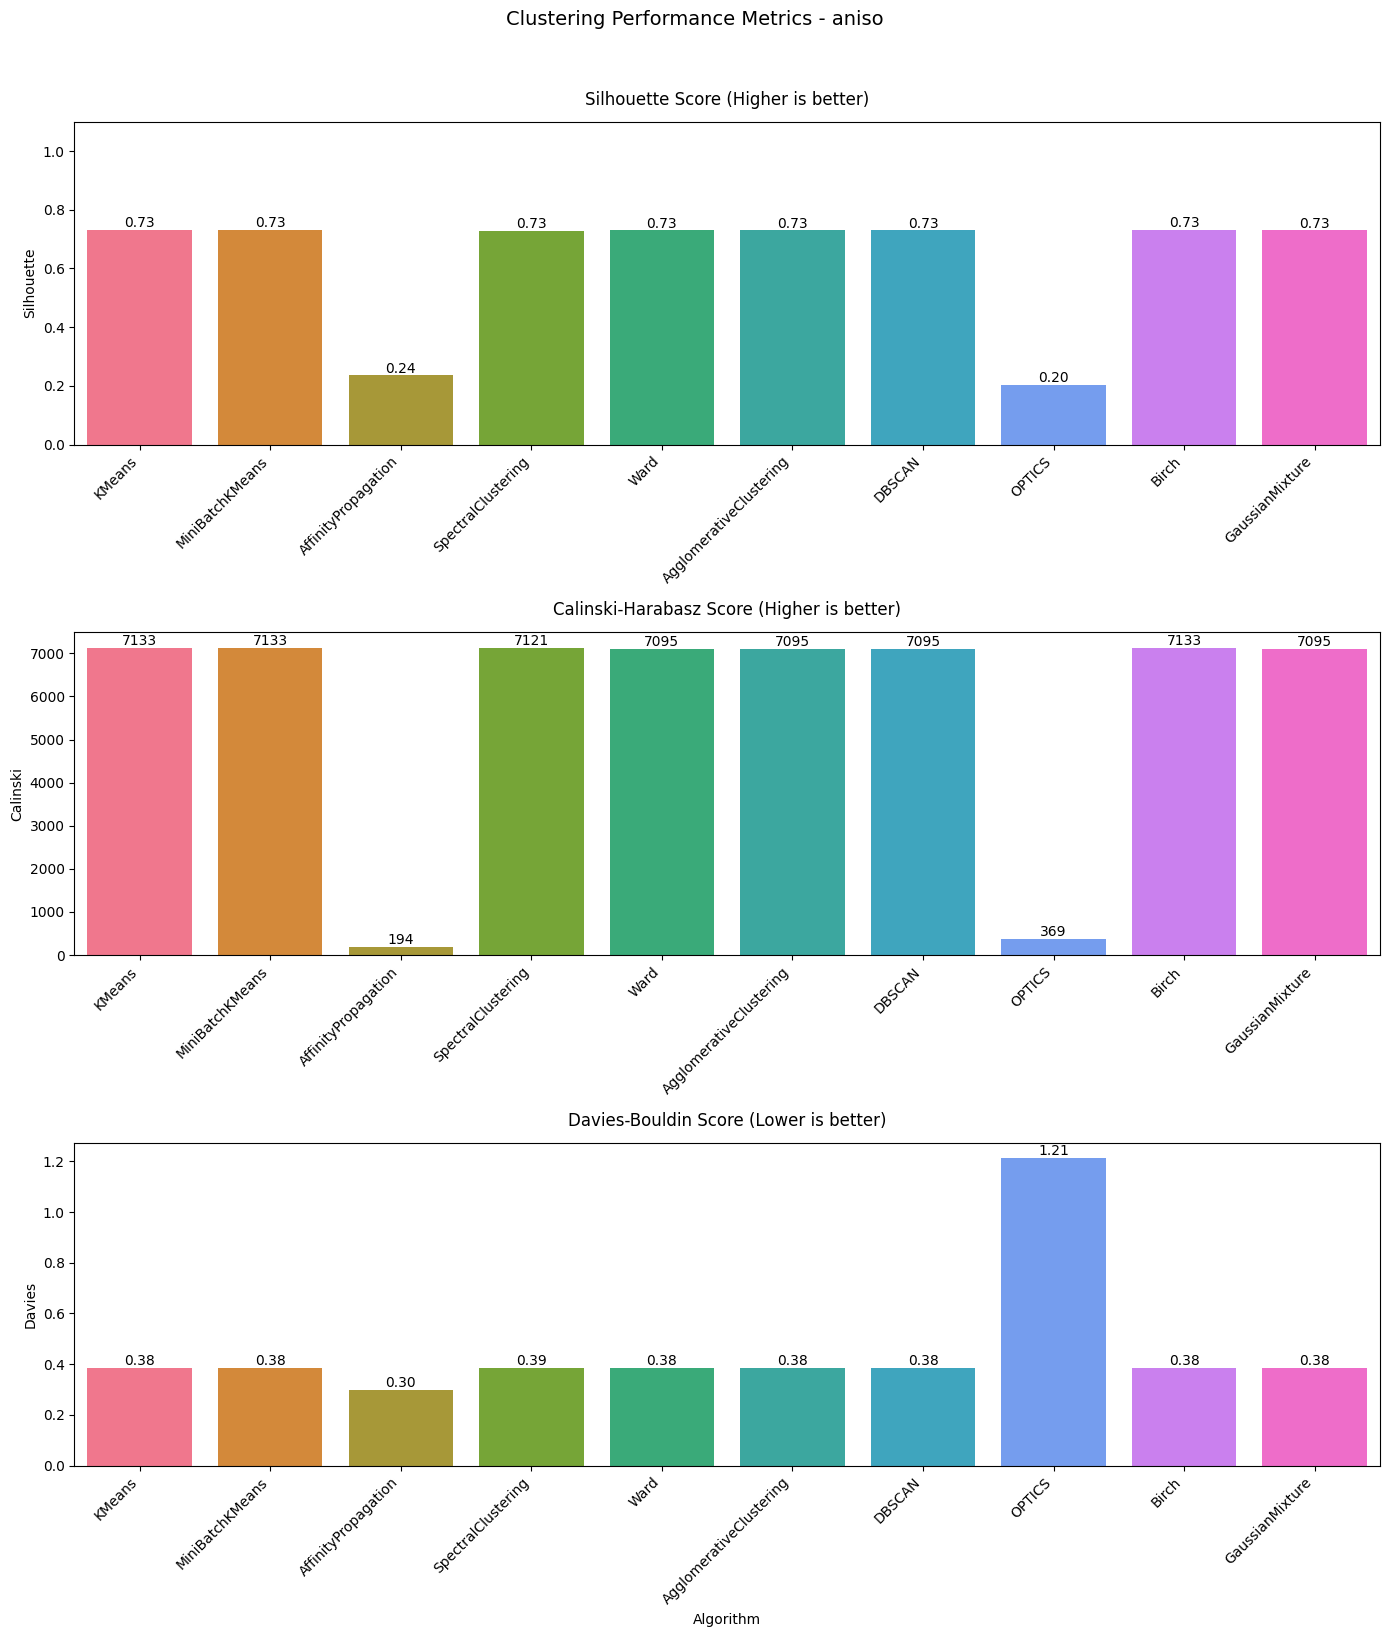

<ipython-input-28-9e4f829d7dd1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Silhouette', data=dataset_df,
<ipython-input-28-9e4f829d7dd1>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-28-9e4f829d7dd1>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Calinski', data=dataset_df,
<ipython-input-28-9e4f829d7dd1>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(

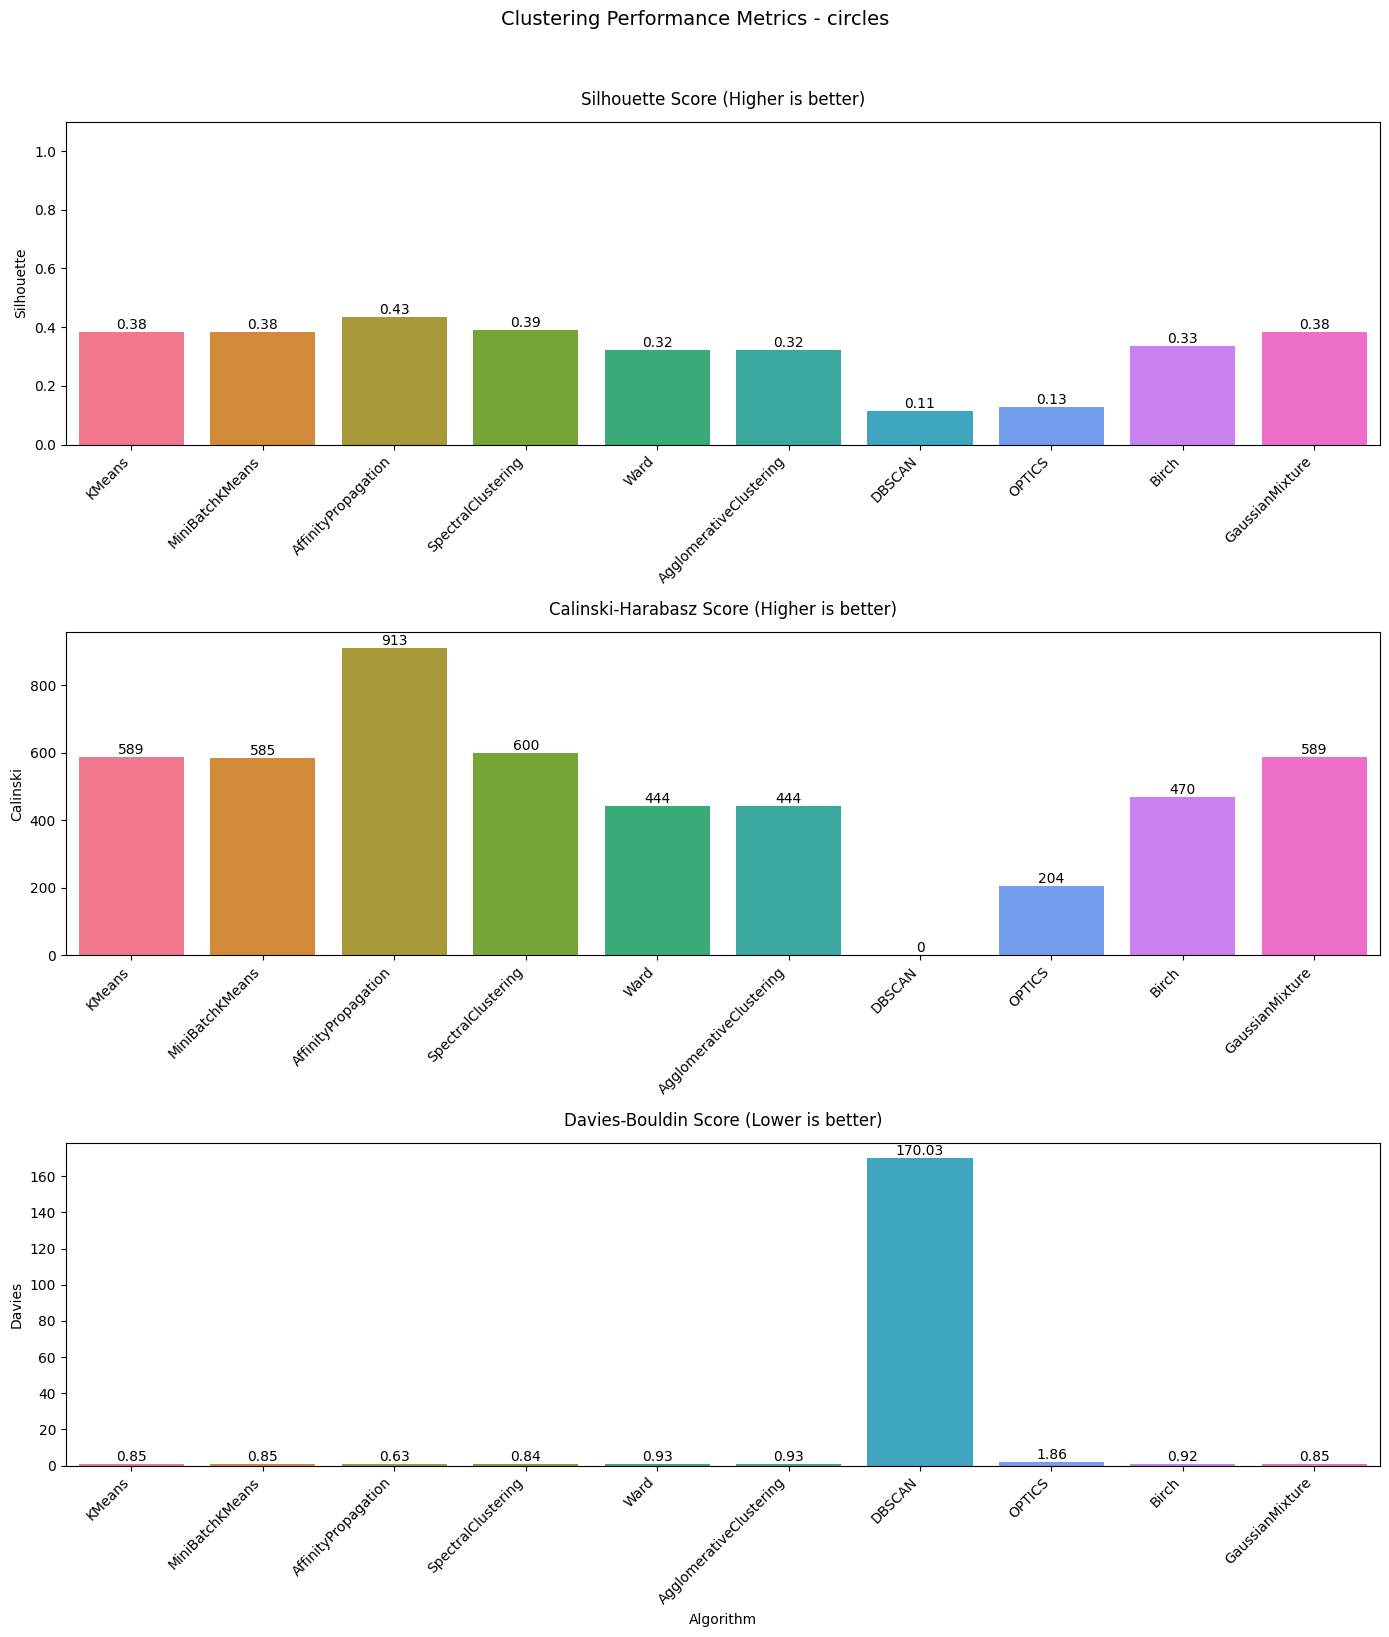

<ipython-input-28-9e4f829d7dd1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Silhouette', data=dataset_df,
<ipython-input-28-9e4f829d7dd1>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-28-9e4f829d7dd1>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Calinski', data=dataset_df,
<ipython-input-28-9e4f829d7dd1>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(

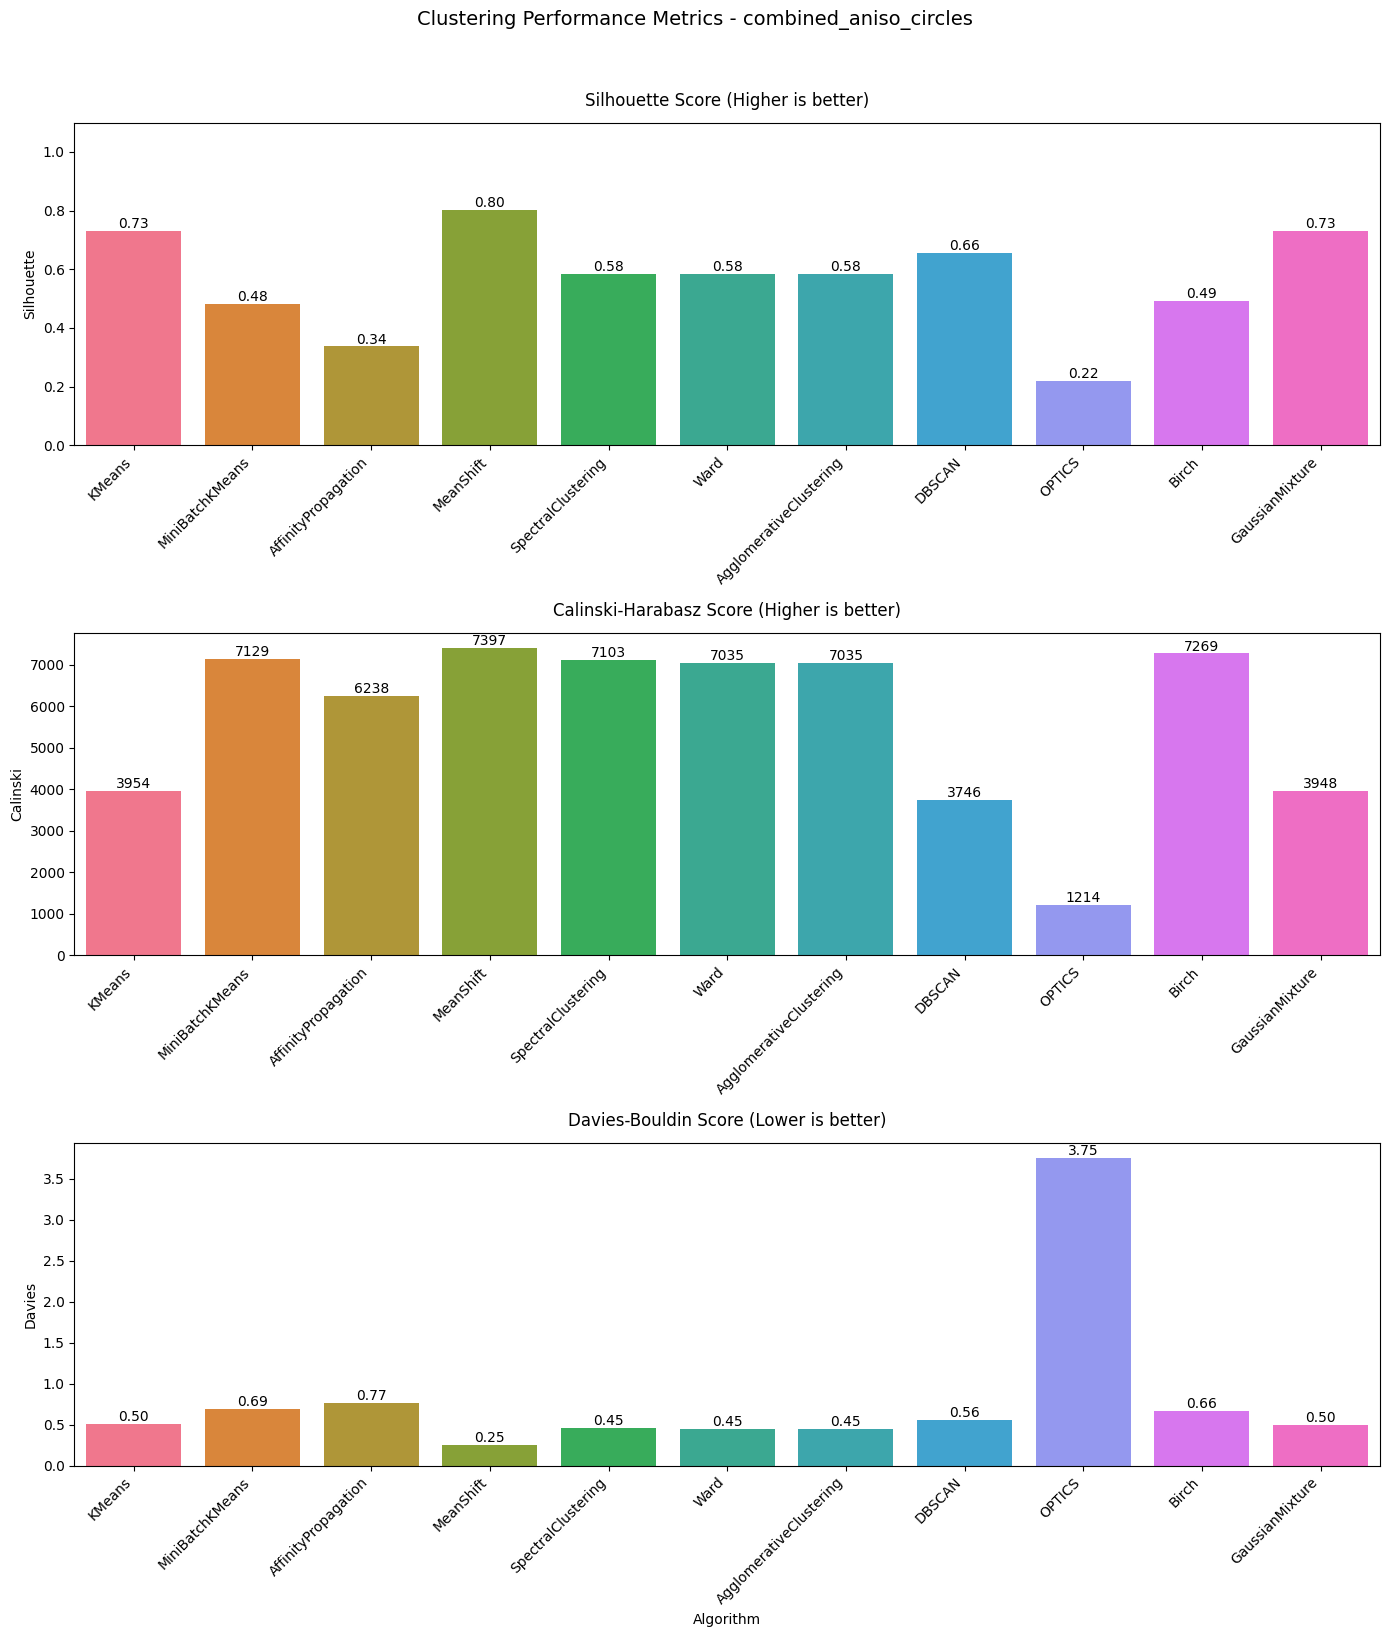

In [28]:
def plot_metrics_comparison(data, dataset_name):
    dataset_df = data[data['Dataset'] == dataset_name].dropna()

    # Create dynamic color palette based on number of algorithms
    num_algorithms = len(dataset_df)
    palette = sns.color_palette("husl", num_algorithms)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16))
    fig.suptitle(f'Clustering Performance Metrics - {dataset_name}', y=1.02, fontsize=14)

    # Silhouette Score (higher is better)
    sns.barplot(x='Algorithm', y='Silhouette', data=dataset_df,
                ax=ax1, palette=palette, saturation=0.9)
    ax1.set_title('Silhouette Score (Higher is better)', pad=12)
    ax1.set_xlabel('')
    ax1.set_ylim(0, 1.1)  # Silhouette score ranges from -1 to 1
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    # Add value annotations
    for p in ax1.patches:
        ax1.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points')

    # Calinski-Harabasz Score (higher is better)
    sns.barplot(x='Algorithm', y='Calinski', data=dataset_df,
                ax=ax2, palette=palette, saturation=0.9)
    ax2.set_title('Calinski-Harabasz Score (Higher is better)', pad=12)
    ax2.set_xlabel('')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

    # Add value annotations
    for p in ax2.patches:
        ax2.annotate(f"{p.get_height():.0f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points')

    # Davies-Bouldin Score (lower is better)
    sns.barplot(x='Algorithm', y='Davies', data=dataset_df,
                ax=ax3, palette=palette, saturation=0.9)
    ax3.set_title('Davies-Bouldin Score (Lower is better)', pad=12)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')

    # Add value annotations
    for p in ax3.patches:
        ax3.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

# Plot metrics for each dataset
for dataset in datasets.keys():
    plot_metrics_comparison(results_df, dataset)


## 7. Best Algorithm Identification

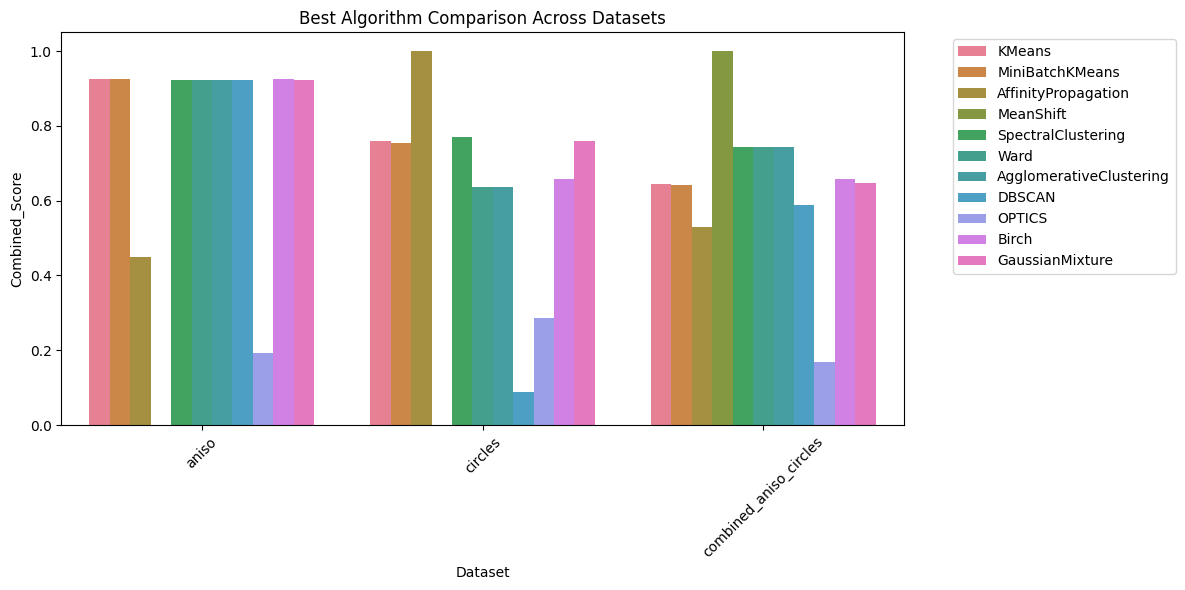


Best Algorithm for Each Dataset:
aniso: KMeans (Score: 0.924)
circles: AffinityPropagation (Score: 1.000)
combined_aniso_circles: MeanShift (Score: 1.000)


In [29]:
normalized_df = results_df.copy()
for dataset in normalized_df['Dataset'].unique():
    dataset_mask = normalized_df['Dataset'] == dataset

    # Higher is better for these metrics
    silhouette_max = normalized_df.loc[dataset_mask, 'Silhouette'].max()
    normalized_df.loc[dataset_mask, 'Silhouette'] /= silhouette_max

    calinski_max = normalized_df.loc[dataset_mask, 'Calinski'].max()
    normalized_df.loc[dataset_mask, 'Calinski'] /= calinski_max

    # Lower is better for Davies
    davies_min = normalized_df.loc[dataset_mask, 'Davies'].min()
    normalized_df.loc[dataset_mask, 'Davies'] = davies_min / normalized_df.loc[dataset_mask, 'Davies']

# Calculate combined score
normalized_df['Combined_Score'] = (normalized_df['Silhouette'] +
                                  normalized_df['Calinski'] +
                                  normalized_df['Davies']) / 3

# Plot best algorithms
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='Combined_Score', hue='Algorithm', data=normalized_df)
plt.title('Best Algorithm Comparison Across Datasets')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display best algorithm for each dataset
print("\nBest Algorithm for Each Dataset:")
for dataset in normalized_df['Dataset'].unique():
    best = normalized_df[normalized_df['Dataset'] == dataset].nlargest(1, 'Combined_Score')
    print(f"{dataset}: {best['Algorithm'].values[0]} (Score: {best['Combined_Score'].values[0]:.3f})")